In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
from utils import *

In [3]:
# See if data is Gaussian
base = '/Users/theoares/Dropbox (MIT)/research/0nubb/meas/'
ens = '24I/ml0p01'
data_dir = base + ens + '/hdf5'

l = 24
t = 64
L = Lattice(l, t)

k1_list = []
k2_list = []
for n in range(2, 10):
    k1_list.append([-n, 0, n, 0])
    k2_list.append([0, n, n, 0])
k1_list = np.array(k1_list)
k2_list = np.array(k2_list)
q_list = k2_list - k1_list
print('Number of total momenta: ' + str(len(q_list)))
cfgs = []
for (dirpath, dirnames, file) in os.walk(data_dir):
    cfgs.extend(file)
for idx, cfg in enumerate(cfgs):
    cfgs[idx] = data_dir + '/' + cfgs[idx]
n_cfgs = len(cfgs)
print('Reading ' + str(n_cfgs) + ' configs.')

Number of total momenta: 8
Reading 10 configs.


In [4]:
for q_idx, q in enumerate(q_list):
    print('Momentum index: ' + str(q_idx))
    print('Momentum is: ' + str(q))
    k1, k2, props_k1, props_k2, props_q, GV, GA, GO = readfiles(cfgs, q, True)

Momentum index: 0
Momentum is: [2 2 0 0]
Momentum index: 1
Momentum is: [3 3 0 0]
Momentum index: 2
Momentum is: [4 4 0 0]
Momentum index: 3
Momentum is: [5 5 0 0]
Momentum index: 4
Momentum is: [6 6 0 0]
Momentum index: 5
Momentum is: [7 7 0 0]
Momentum index: 6
Momentum is: [8 8 0 0]
Momentum index: 7
Momentum is: [9 9 0 0]


In [34]:
# Playing around with Lambda fits for the 32I lattice
ensembles = ['32I/ml0p004/', '32I/ml0p006/']
l, t = 32, 64
ainv = 2.382                                # GeV
mpi_list = [0.3020, 0.3597]                 # GeV
amq_list = [0.004, 0.006]
L = Lattice(l, t)
a_fm = hbarc / ainv
n_ens = len(ensembles)
ampi_list = [mpi_list[i] / ainv for i in range(n_ens)]

In [3]:
file_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'Z_gamma_Lambda.h5' for ens in ensembles]
Fs = [h5py.File(fpath, 'r') for fpath in file_paths]
k_list = [f['momenta'][()] for f in Fs]
mom_list = [[L.to_linear_momentum(k, datatype=np.float64) for k in k_list[i]] for i in range(n_ens)]
mu_list = [np.array([get_energy_scale(q, a_fm, L) for q in k_list[i]]) for i in range(n_ens)]

In [4]:
k_list_ens = [f['momenta'][()] for f in Fs]
assert np.array_equal(k_list_ens[0], k_list_ens[1])         # make sure each ensemble has same momentum modes
k_list = k_list_ens[0]
mom_list = np.array([L.to_linear_momentum(k, datatype=np.float64) for k in k_list])
mu_list = np.array([get_energy_scale(q, a_fm, L) for q in k_list])

In [5]:
k_list

array([[2, 2, 0, 0],
       [3, 3, 0, 0],
       [4, 4, 0, 0],
       [5, 5, 0, 0],
       [6, 6, 0, 0],
       [7, 7, 0, 0],
       [8, 8, 0, 0],
       [9, 9, 0, 0]])

In [6]:
# Get renormalization coefficients (not chirally extrapolated)
Zq_list = [np.real(f['Zq'][()]) for f in Fs]
n_momenta, n_boot = [Zq.shape[0] for Zq in Zq_list], [Zq.shape[1] for Zq in Zq_list]
ZV_list = [np.real(f['ZV'][()]) for f in Fs]
ZA_list = [np.real(f['ZA'][()]) for f in Fs]
Z_list = []
for idx in range(n_ens):
    Z = np.zeros((5, 5, n_momenta[idx], n_boot[idx]), dtype = np.float64)
    f = Fs[idx]
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(f[key][()])
    Z_list.append(Z)
# Get Lambda factor. Lambdas are bootstrapped, but the boots are uncorrelated. Shape is (n_ens, 5, 5, n_momenta, n_boot)
colors = ['r', 'c', 'm']
Lambda_list = [np.real(f['Lambda'][()]) for f in Fs]

In [10]:
mom_list

array([[0.39269908, 0.39269908, 0.        , 0.        ],
       [0.58904862, 0.58904862, 0.        , 0.        ],
       [0.78539816, 0.78539816, 0.        , 0.        ],
       [0.9817477 , 0.9817477 , 0.        , 0.        ],
       [1.17809725, 1.17809725, 0.        , 0.        ],
       [1.37444679, 1.37444679, 0.        , 0.        ],
       [1.57079633, 1.57079633, 0.        , 0.        ],
       [1.76714587, 1.76714587, 0.        , 0.        ]])

<IPython.core.display.Javascript object>


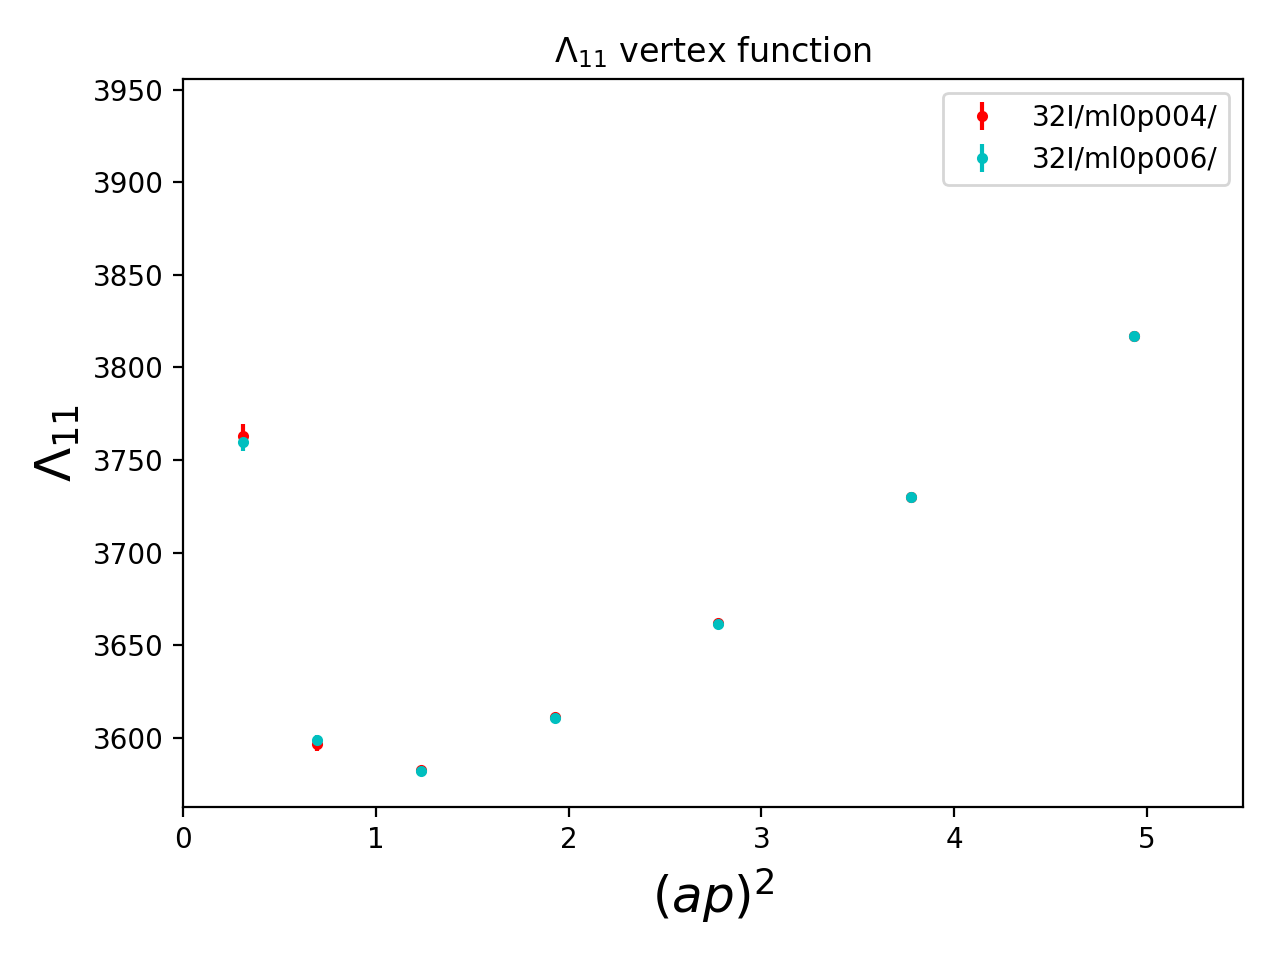

In [11]:
# Lambda11
Lambda11_mu_list = [np.mean(Lambda[0, 0], axis = 1) for Lambda in Lambda_list]
Lambda11_sigma_list = [np.std(Lambda[0, 0], axis = 1, ddof = 1) for Lambda in Lambda_list]
plt.figure()
for idx in range(n_ens):
    #plt.errorbar([square(k) for k in mom_list[idx]], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
# plt.ylim((0.6, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# do a correlated fit first just cause it's easy (shouldn't use this for final analysis)
n_boot = Lambda_list[0].shape[-1]
multiplet = [[0, 0]]        # for testing purposes
mass_list = np.array(mpi_list)    # TODO play around with this, can also be mq_list
Lambda_fit = np.zeros(Lambda_list[0].shape, dtype = np.float64)
for mult_idx in multiplet:
    for mom_idx in range(len(mom_list)):
        print('Fitting for momentum ' + str(mom_idx))
        fit_data = np.transpose(np.array([Lambda[mult_idx[0], mult_idx[1], mom_idx] for Lambda in Lambda_list], dtype = np.float64))
        fit_params, chi2, y_extrap = corr_linear_fit(mass_list, fit_data, 0)    # extrapolate to chiral limit m = 0
        Lambda_fit[mult_idx[0], mult_idx[1], mom_idx] = y_extrap

Fitting for momentum 0
Extrapolated Lambda_ij: 3777.5403542343456 \pm 41.993621989956644
Fitting for momentum 1
Extrapolated Lambda_ij: 3586.76822586235 \pm 23.149273256574595
Fitting for momentum 2
Extrapolated Lambda_ij: 3583.5631060050246 \pm 11.54664068261174
Fitting for momentum 3
Extrapolated Lambda_ij: 3612.532930270948 \pm 8.50687177619476
Fitting for momentum 4
Extrapolated Lambda_ij: 3664.072912618931 \pm 8.169013013453856
Fitting for momentum 5
Extrapolated Lambda_ij: 3731.854648522122 \pm 8.226571425946338
Fitting for momentum 6
Extrapolated Lambda_ij: 3817.281155599238 \pm 9.292457195497732
Fitting for momentum 7
Extrapolated Lambda_ij: 3936.2529432110377 \pm 10.01747396689018


<IPython.core.display.Javascript object>


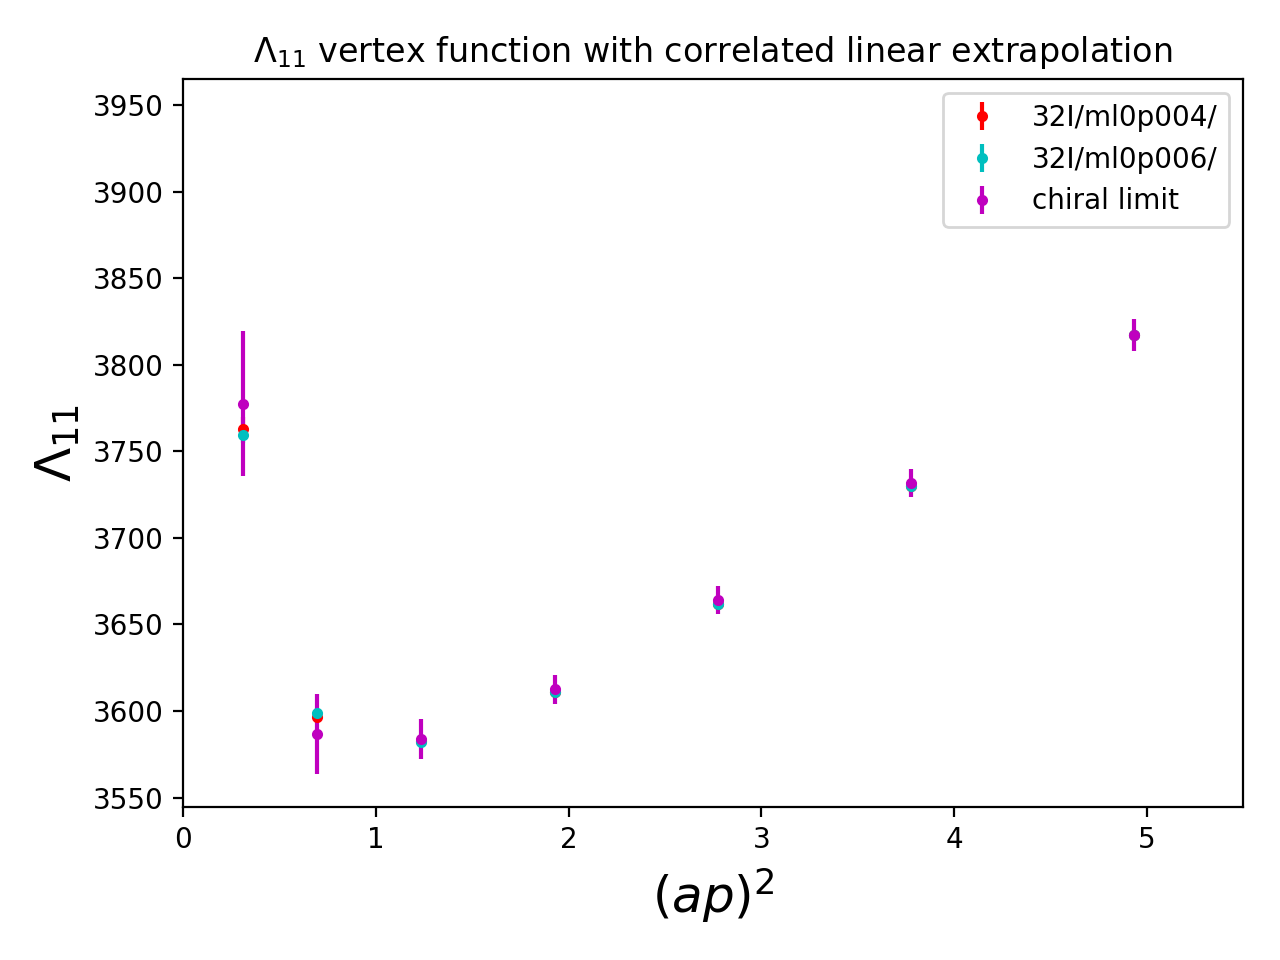

In [13]:
# plot with extrapolated value
Lambda11_fit_mu = np.mean(Lambda_fit[0, 0], axis = 1)
Lambda11_fit_sigma = np.std(Lambda_fit[0, 0], axis = 1, ddof = 1)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) for k in mom_list], Lambda11_fit_mu, Lambda11_fit_sigma, fmt = '.', c = colors[2], label = 'chiral limit')
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function with correlated linear extrapolation')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
Lambda_list[0][mult_idx[0], mult_idx[1]].shape
Lambda_List[ens_idx][i, j, momenta, boot]

(8, 50)

In [38]:
# do an uncorrelated fit with Superboot objects. There will be two Superboot objects, one for each ensemble.
Lambda_uncorr_lin_mu = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
Lambda_uncorr_lin_sigma = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
mass_list = np.array(mpi_list)
# mass_list = np.array(amq_list)
for mult_idx in multiplet:
    for mom_idx in range(len(mom_list)):
        print('Fitting for momentum ' + str(mom_idx))
        Lambda_superboot = []    # create n_ens Superboot objects
        for ii in range(n_ens):
            tmp = Superboot(n_ens)
            tmp.populate_ensemble(Lambda_list[ii][mult_idx[0], mult_idx[1], mom_idx], ii)
            Lambda_superboot.append(tmp)
#         fit_params, chi2, y_extrap = uncorr_linear_fit(mass_list, Lambda_superboot, 0)
        fit_params, chi2, y_extrap = uncorr_linear_fit(mass_list, Lambda_superboot, 0.140)
        Lambda_uncorr_lin_mu[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.mean
        Lambda_uncorr_lin_sigma[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.std

Fitting for momentum 0
Extrapolated result for Lambda_ij: 3767.352138170787 \pm 16.60442447091798
Fitting for momentum 1
Extrapolated result for Lambda_ij: 3592.902329148902 \pm 10.104209341622813
Fitting for momentum 2
Extrapolated result for Lambda_ij: 3583.1444587694295 \pm 7.140500929997943
Fitting for momentum 3
Extrapolated result for Lambda_ij: 3611.980529277412 \pm 5.29318158914088
Fitting for momentum 4
Extrapolated result for Lambda_ij: 3663.273626042569 \pm 4.763553066295313
Fitting for momentum 5
Extrapolated result for Lambda_ij: 3731.277531602883 \pm 4.808788485697665
Fitting for momentum 6
Extrapolated result for Lambda_ij: 3817.2580808854395 \pm 5.154546182225181
Fitting for momentum 7
Extrapolated result for Lambda_ij: 3936.363790141458 \pm 5.663511792809929


<IPython.core.display.Javascript object>


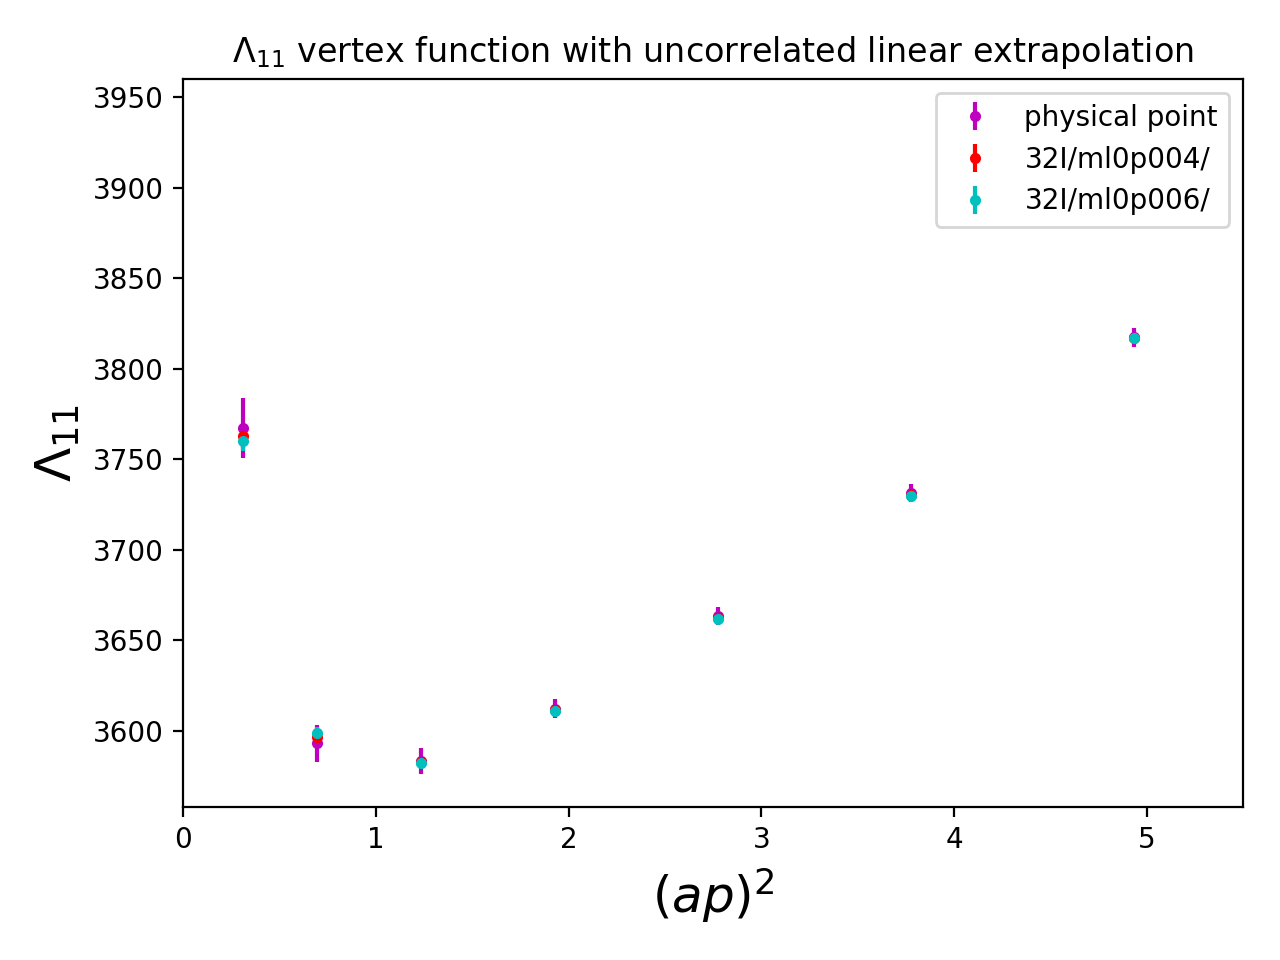

In [40]:
plt.figure()
plt.errorbar([square(k) for k in mom_list], Lambda_uncorr_lin_mu[mult_idx[0], mult_idx[1]], Lambda_uncorr_lin_sigma[mult_idx[0], mult_idx[1]], fmt = '.', c = colors[2], label = 'physical point')
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function with uncorrelated linear extrapolation')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
print(Lambda_uncorr_fit_sigma[0, 0])
print(Lambda11_sigma_list)

[27.47119269 17.29278961 12.40058846  9.30129751  8.3644148   8.45855771
  9.07351193  9.95024989]
[array([6.6242394 , 3.5543942 , 1.4256145 , 0.97060204, 0.87863094,
       0.8747224 , 0.9319115 , 1.0400048 ], dtype=float32), array([5.0075626, 3.0132034, 1.6523247, 1.349686 , 1.2077928, 1.2354344,
       1.3316491, 1.4421334], dtype=float32)]


In [47]:
# do an uncorrelated fit with Superboot objects. There will be two Superboot objects, one for each ensemble.
Lambda_uncorr_const_mu = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
Lambda_uncorr_const_sigma = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
mass_list = np.array(mpi_list)
# mass_list = np.array(amq_list)
for mult_idx in multiplet:
    for mom_idx in range(len(mom_list)):
        print('Fitting for momentum ' + str(mom_idx))
        Lambda_superboot = []    # create n_ens Superboot objects
        for ii in range(n_ens):
            tmp = Superboot(n_ens)
            tmp.populate_ensemble(Lambda_list[ii][mult_idx[0], mult_idx[1], mom_idx], ii)
            Lambda_superboot.append(tmp)
#         fit_params, chi2, y_extrap = uncorr_const_fit(mass_list, Lambda_superboot, 0)
        chi2, y_extrap = uncorr_const_fit(mass_list, Lambda_superboot, 0.140)
        Lambda_uncorr_const_mu[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.mean
        Lambda_uncorr_const_sigma[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.std

Fitting for momentum 0
Extrapolated result for Lambda_ij: 3760.963668015185 \pm 3.99462166171645
Fitting for momentum 1
Extrapolated result for Lambda_ij: 3597.840200706732 \pm 2.298439098738074
Fitting for momentum 2
Extrapolated result for Lambda_ij: 3582.343068637557 \pm 1.0793878868076092
Fitting for momentum 3
Extrapolated result for Lambda_ij: 3611.0694949723124 \pm 0.7880011982030083
Fitting for momentum 4
Extrapolated result for Lambda_ij: 3661.958190995056 \pm 0.7105144349610851
Fitting for momentum 5
Extrapolated result for Lambda_ij: 3730.1515095772907 \pm 0.713897668376648
Fitting for momentum 6
Extrapolated result for Lambda_ij: 3817.179426614176 \pm 0.7635170381846991
Fitting for momentum 7
Extrapolated result for Lambda_ij: 3936.552322053197 \pm 0.8435366083601569


<IPython.core.display.Javascript object>


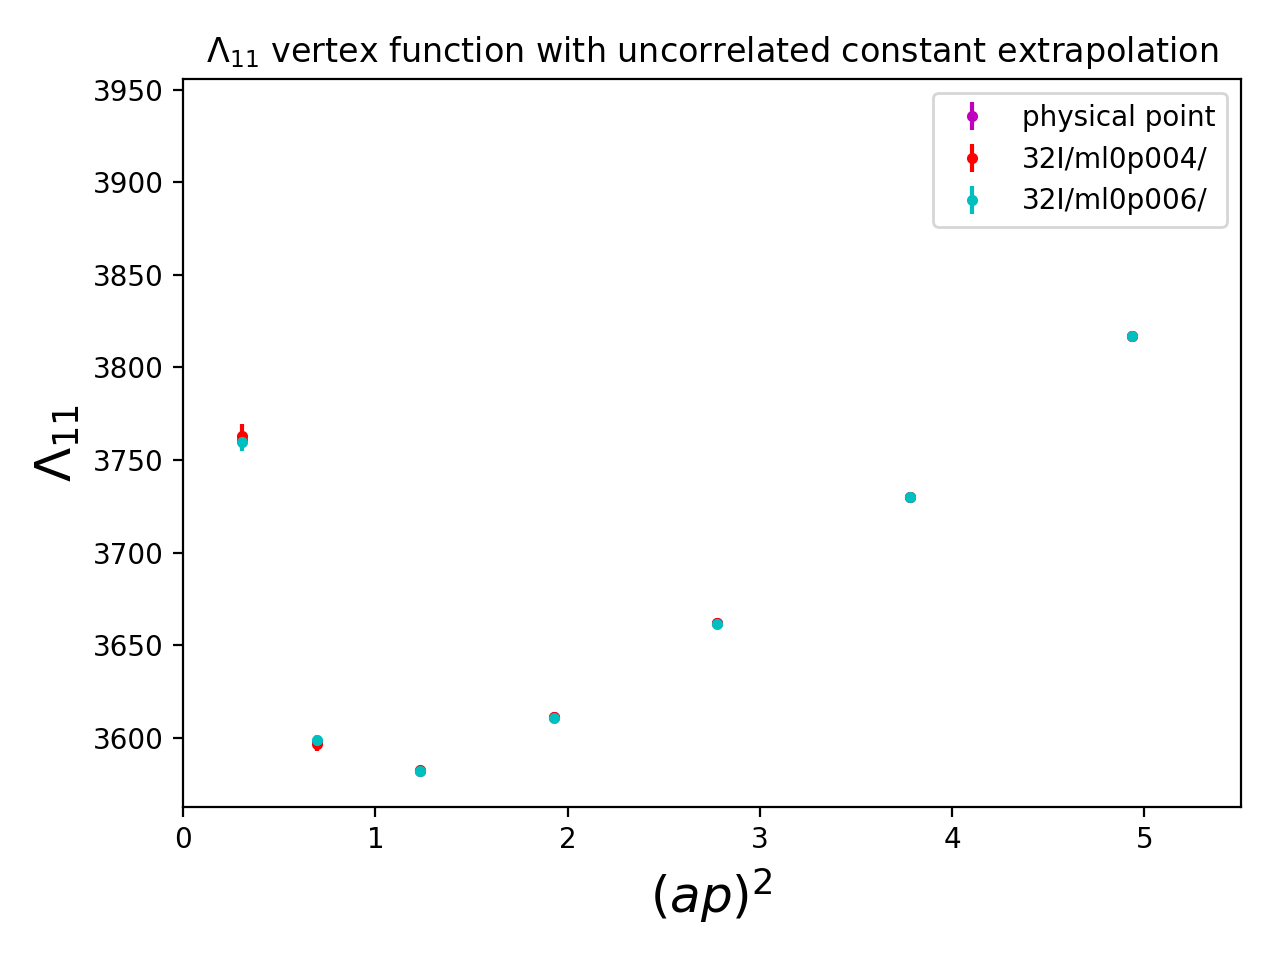

In [48]:
plt.figure()
plt.errorbar([square(k) for k in mom_list], Lambda_uncorr_const_mu[mult_idx[0], mult_idx[1]], Lambda_uncorr_const_sigma[mult_idx[0], mult_idx[1]], fmt = '.', c = colors[2], label = 'physical point')
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function with uncorrelated constant extrapolation')
plt.legend()
plt.tight_layout()
plt.show()